# Fig.5 Comparison of the model performances

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

In [2]:
#add description of the notebook
# this file generates figure 5
#modified the code provided by Gilpin!!..
##modified by Anuj Mishra

In [3]:
print(sys.path)

['/app/work/notebooks', '/usr/local/lib/python310.zip', '/usr/local/lib/python3.10', '/usr/local/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/site-packages']


In [4]:
sys.path.append(os.path.join(os.getcwd(),'../repos/dysts/'))

In [5]:
sys.path.append(os.path.join(os.getcwd(),'../repos/darts/'))

In [6]:
print(sys.path)

['/app/work/notebooks', '/usr/local/lib/python310.zip', '/usr/local/lib/python3.10', '/usr/local/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/site-packages', '/app/work/notebooks/../repos/dysts/', '/app/work/notebooks/../repos/darts/']


In [7]:
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

loaded!


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Forecasting Benchmark Results

In [9]:
import os
import json

GRANULARITY = 100
#DATE = 221025 # noise level 0.8, not including RBF
DATE = 220812 # noise level 0.2, not including RBF

#/results/221025_results_test_univariate__pts_per_period_ # large noise 
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

#220315_results_test_univariate__pts_per_period_ #Initial try
#220326_results_test_univariate__pts_per_period_
#/results/220426_results_test_univariate__pts_per_period_

with open(
    os.getcwd()
    + "/../repos/dysts/benchmarks/results/" + str(DATE) + "_results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12_noise.json",
    "r",
) as file:
    all_results = json.load(file)

#220428
# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)



## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue            
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)

# HS Remove unimportant methods
for equation_name in all_results:
    for model_name in ['FFT', 'FourTheta', 'AutoARIMA', 'LSS_Takens']:
        #all_results[equation_name].pop(model_name, None)
        del all_results[equation_name][model_name]

# HS using local darts
#sys.path.append(os.path.join(os.getcwd(),'../../darts/'))
import darts
from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")
    

    #/results/221025_results_test_univariate__pts_per_period_
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

if DATE == 220812:
    hist_values_low = hist_values.copy()
elif DATE == 221025:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

In [10]:
#hist_values_high.head()

### Compare different forecasting models

In [11]:
hist_values_high=hist_values_low

In [12]:
#dflo = pd.DataFrame.from_dict(hist_values_low) ##########Commented out! HS
dflo = pd.DataFrame.from_dict(hist_values_high)
dflo["Granularity"] = "Coarse"

dfhi = pd.DataFrame.from_dict(hist_values_high)
dfhi["Granularity"] = "Fine"
#data = pd.merge(dflo, dfhi, how="outer")
data = pd.merge(dfhi, dflo, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
#sort_order = np.argsort(all_medians)
sort_order = np.argsort(all_means)

#data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")
data_long = pd.melt(dfhi, value_vars=all_model_names[sort_order], id_vars="Granularity")



In [13]:
data_violin_low=data_long

In [14]:
data_violin_low['variable'] = data_violin_low['variable'].replace(
    to_replace=['NLSS_Takens', 'LinearRegressionModel', 'ExponentialSmoothing', 'TransformerModel', 'NBEATSModel', 'RNNModel', 'TCNModel' ], 
    value=['PNL-SS', 'LinearRegression', 'ExpSmoothing', 'Transformer', 'NBEATS', 'RNN', 'TCN' ])

In [15]:
all_model_names[sort_order]

array(['NBEATSModel', 'NLSS_Takens', 'TransformerModel', 'RNNModel',
       'TCNModel', 'Theta', 'RandomForest', 'NaiveSeasonal', 'NaiveDrift',
       'ARIMA', 'LinearRegressionModel', 'NaiveMean', 'KalmanForecaster',
       'ExponentialSmoothing'], dtype='<U21')

In [16]:
order_low=['NBEATS', 'PNL-SS', 'Transformer', 'RNN', 'TCN',
        'Theta','RandomForest',  'NaiveSeasonal',
       'NaiveDrift', 'ARIMA', 'LinearRegression', 'NaiveMean', 'KalmanForecaster', 'ExpSmoothing']

In [17]:
data_violin_low=data_violin_low.rename(columns = {'variable':'Models', 'value': 'SMAPE'}) 

In [18]:
import os
import json

GRANULARITY = 100
DATE = 221025 # noise level 0.8, not including RBF
#DATE = 220812 # noise level 0.2, not including RBF

#/results/221025_results_test_univariate__pts_per_period_ # large noise 
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

#220315_results_test_univariate__pts_per_period_ #Initial try
#220326_results_test_univariate__pts_per_period_
#/results/220426_results_test_univariate__pts_per_period_

with open(
    os.getcwd()
    + "/../repos/dysts/benchmarks/results/" + str(DATE) + "_results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12_noise.json",
    "r",
) as file:
    all_results = json.load(file)

#220428
# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)



## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue            
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)

# HS Remove unimportant methods
for equation_name in all_results:
    for model_name in ['FFT', 'FourTheta', 'AutoARIMA', 'LSS_Takens']:
        #all_results[equation_name].pop(model_name, None)
        del all_results[equation_name][model_name]

# HS using local darts
#sys.path.append(os.path.join(os.getcwd(),'../../darts/'))
import darts
from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")
    

    #/results/221025_results_test_univariate__pts_per_period_
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

if DATE == 220812:
    hist_values_low = hist_values.copy()
elif DATE == 221025:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

### Compare different forecasting models

In [19]:
#hist_values_high=hist_values_low

In [20]:
#dflo = pd.DataFrame.from_dict(hist_values_low) ##########Commented out! HS
dflo = pd.DataFrame.from_dict(hist_values_high)
dflo["Granularity"] = "Coarse"

dfhi = pd.DataFrame.from_dict(hist_values_high)
dfhi["Granularity"] = "Fine"
#data = pd.merge(dflo, dfhi, how="outer")
data = pd.merge(dfhi, dflo, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
#sort_order = np.argsort(all_medians)
sort_order = np.argsort(all_means)

#data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")
data_long = pd.melt(dfhi, value_vars=all_model_names[sort_order], id_vars="Granularity")



In [21]:
data_violin_high=data_long

In [22]:
data_violin_high['variable'] = data_violin_high['variable'].replace(
    to_replace=['NLSS_Takens', 'LinearRegressionModel', 'ExponentialSmoothing', 'TransformerModel', 'NBEATSModel', 'RNNModel', 'TCNModel' ], 
    value=['PNL-SS', 'LinearRegression', 'ExpSmoothing', 'Transformer', 'NBEATS', 'RNN', 'TCN' ])

In [23]:
all_model_names[sort_order]

array(['NLSS_Takens', 'NBEATSModel', 'TransformerModel', 'TCNModel',
       'RNNModel', 'RandomForest', 'Theta', 'ARIMA', 'NaiveSeasonal',
       'NaiveDrift', 'LinearRegressionModel', 'ExponentialSmoothing',
       'NaiveMean', 'KalmanForecaster'], dtype='<U21')

In [24]:
order_high=['PNL-SS', 'NBEATS', 'Transformer', 'TCN',
       'RNN', 'RandomForest', 'Theta', 'ARIMA', 'NaiveSeasonal',
       'NaiveDrift', 'LinearRegression', 'ExpSmoothing',
       'NaiveMean', 'KalmanForecaster']

In [25]:
data_violin_high=data_violin_high.rename(columns = {'variable':'Models', 'value': 'SMAPE'}) 

/tmp/ipykernel_27733/3136831806.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_27733/3136831806.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_27733/3136831806.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.pointplot(
/tmp/ipykernel_27733/3136831806.py:22: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_27733/3136831806.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), 

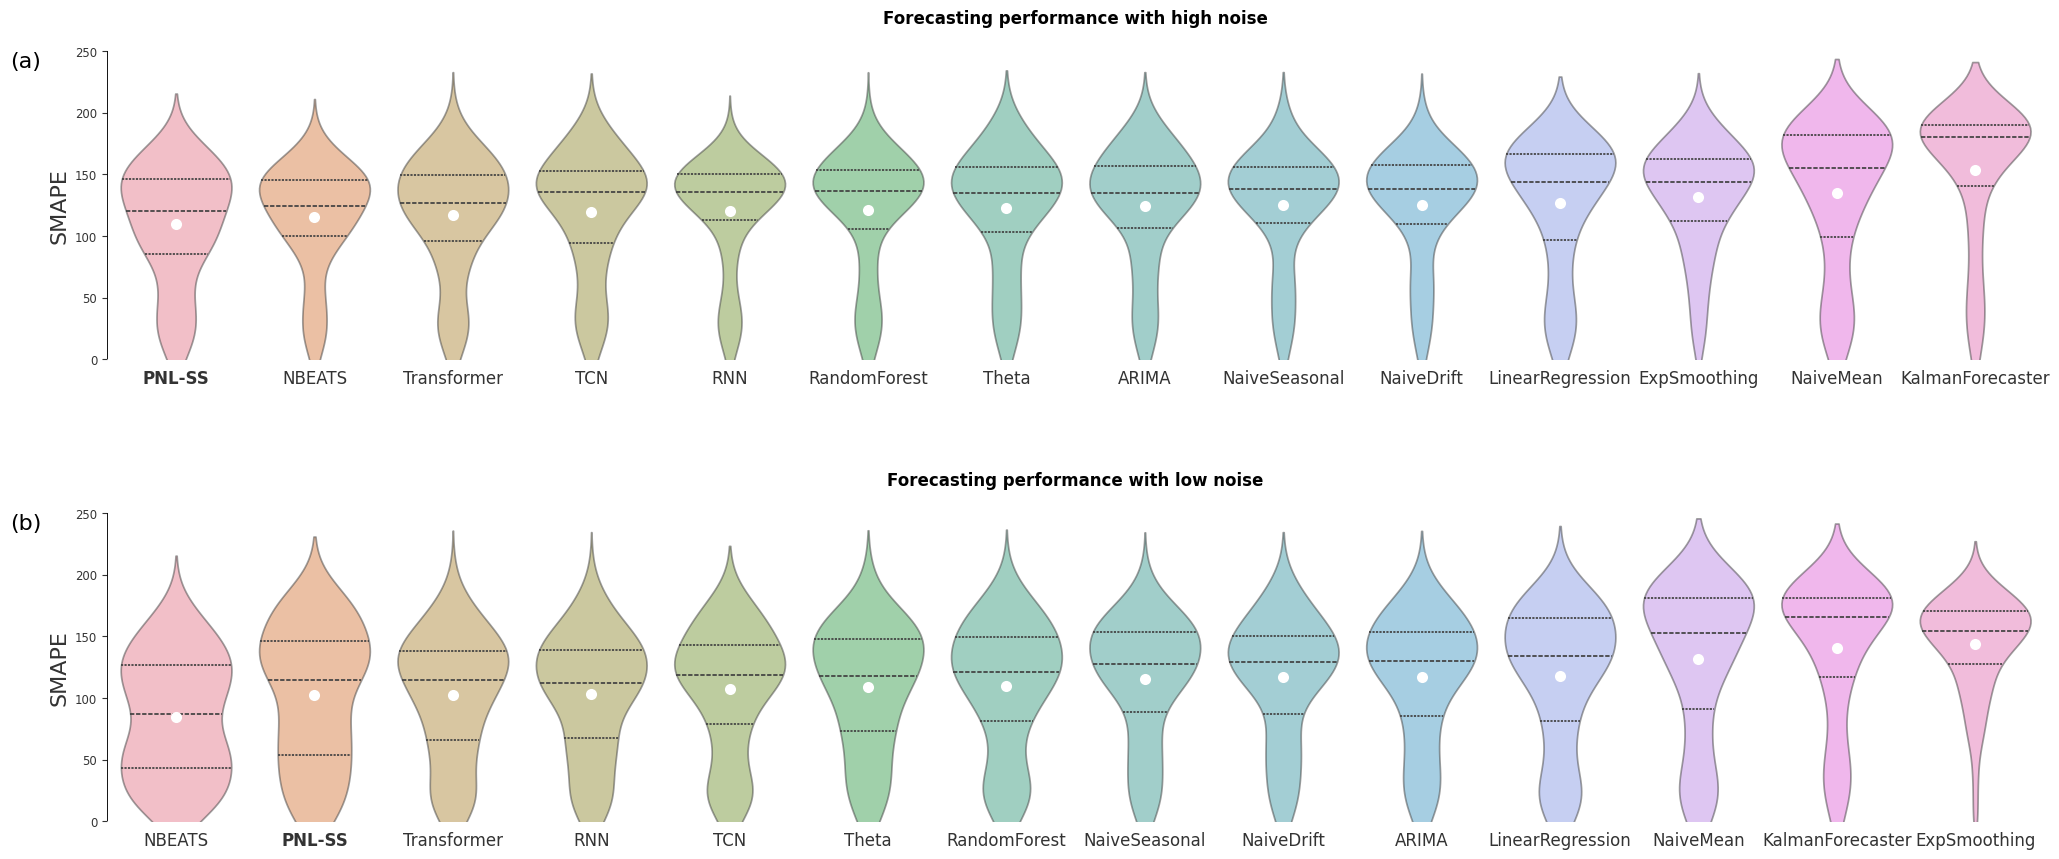

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(25, 10))
# Add some space between the title and the subplot
ax1.set_title('Forecasting performance with high noise', fontweight='bold', pad=20)
ax2.set_title('Forecasting performance with low noise', fontweight='bold', pad=20)

sns.violinplot(
    data=data_violin_high,
    x="Models",
    y="SMAPE",
    order=order_high,
    #linewidth=0,
    #size=3,
    alpha=0.5,
    split=False,
    scale="area",
    inner="quart",
    #palette="flare_r",
    palette="husl",
    ax=ax1
)

sns.pointplot(
    data=data_violin_high,
    x="Models",
    y="SMAPE",
    order=order_high,
    linewidth=0,
    markersize=8,
    color = "w",
    join=False,
    ci=0,
    #dodge=0.2,
    estimator = np.mean,
    ax=ax1
)

ax1.set_ylim([0, 250])
ymin, ymax = ax1.get_ylim()
ax1.axvline(x=-0.5, ymin=ymin, ymax=ymax, color='black')
ax1.grid(False)
ax1.set_xlabel("")
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.get_xticklabels()[0].set_weight('bold')
ax1.set_ylabel("SMAPE", fontweight='normal',fontsize=16)
ax1.text(-0.05, 1.0,'(a)', transform=ax1.transAxes, fontsize=16, fontweight='normal', va='top')

sns.violinplot(
    data=data_violin_low,
    x="Models",
    y="SMAPE",
    order=order_low,
    #linewidth=0,
    #size=3,
    alpha=0.5,
    split=False,
    scale="area",
    inner="quart",
    hue="Models",
    #palette="flare_r",
    palette="husl",
    ax=ax2
)

sns.pointplot(
    data=data_violin_low,
    x="Models",
    y="SMAPE",
    order=order_low,
    linewidth=0,
    markersize=8,
    color = "w",
    join=False,
    ci=0,
    #dodge=0.2,
    estimator = np.mean,
    ax=ax2
)

ax2.set_ylim([0, 250])
ymin, ymax = ax2.get_ylim()
ax2.axvline(x=-0.5, ymin=ymin, ymax=ymax, color='black')
ax2.grid(False)
ax2.set_xlabel("")
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.get_xticklabels()[1].set_weight('bold')
ax2.set_ylabel("SMAPE", fontweight='normal',fontsize=16)
ax2.text(-0.05, 1.0,'(b)', transform=ax2.transAxes, fontsize=16, fontweight='normal', va='top')
plt.subplots_adjust(hspace=0.5)
# plt.savefig('violin_high_low_PNL_SS.eps', format='eps', dpi=1000, bbox_inches='tight')
# plt.savefig('violin_high_low_PNL_SS.jpg', format='jpg', dpi=1000, bbox_inches='tight')
# plt.savefig('violin_high_low_PNL_SS.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()